In [1]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.syn_data
import matplotlib.pyplot as plt
import os
from matplotlib import colors, cm, gridspec

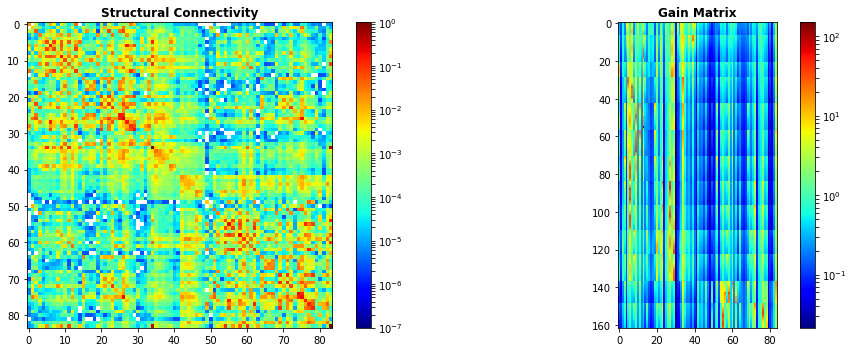

In [2]:
results_dir = 'results/exp7/exp7.1'
os.makedirs(f'{results_dir}/figures',exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
np.random.seed(0)

network = np.load(f'{results_dir}/network.npz')
SC = network['SC']
gain_mat = network['gain_mat']
nn = SC.shape[0]
ns = gain_mat.shape[0]

plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
norm = colors.LogNorm(1e-7,SC.max())
plt.imshow(SC,norm=norm,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title("Structural Connectivity",fontweight="bold")

plt.subplot(1,2,2)
norm = colors.LogNorm(gain_mat.min(),gain_mat.max())
plt.imshow(gain_mat,norm=norm,cmap=cm.jet)
plt.colorbar(fraction=0.046,pad=0.04)
plt.gca().set_title("Gain Matrix",fontweight="bold")
plt.tight_layout()

# plt.savefig(f'{results_dir}/figures/network.png')
# np.savez(f'{results_dir}/network.npz', SC=SC, proj_mat=proj_mat)



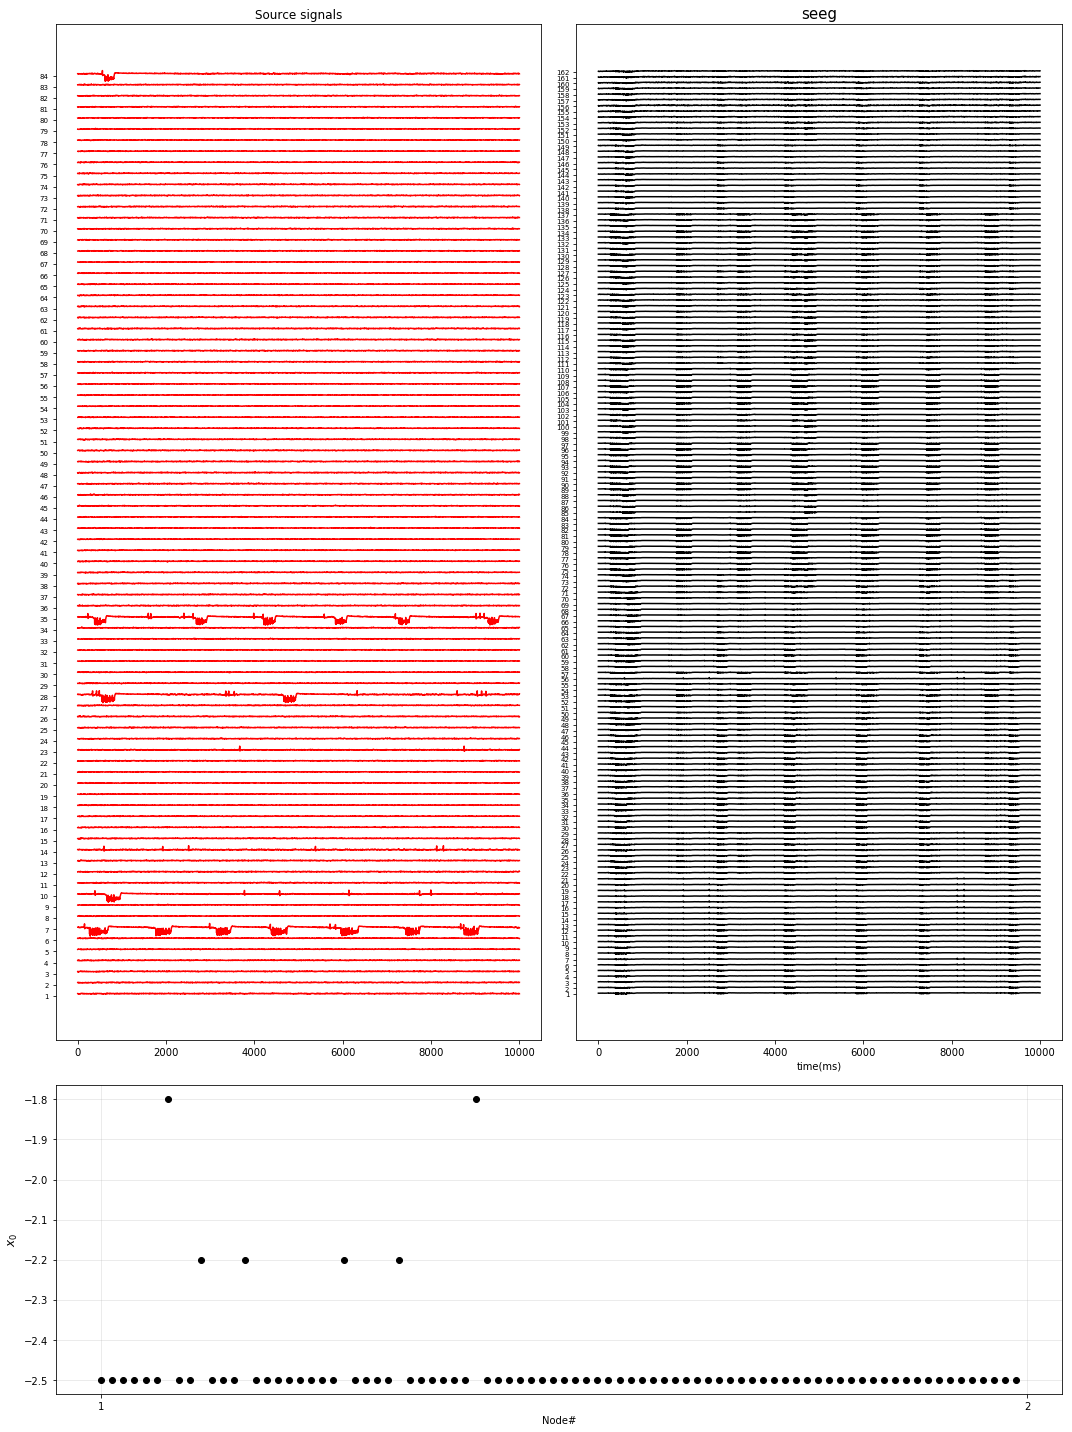

In [3]:
t = np.load(f'{results_dir}/syn_tvb_ez=6-34_pz=22-13-9-27.npz')

src_sig = t['src_sig']
seeg = t['seeg']
seegn = (seeg - np.min(seeg,1)[:,np.newaxis]) / (np.max(seeg,1) - np.min(seeg,1))[:,np.newaxis]
x0 = t['x0']


fig = plt.figure(figsize=(15,20))
gs = gridspec.GridSpec(4, 2)
ax1 = fig.add_subplot(gs[0:3,0])
ax1.plot(src_sig.T/4 + np.r_[0:nn], 'r')
ax1.set_yticks(np.r_[0:nn])
ax1.set_yticklabels(np.r_[0:nn]+1,fontsize=7.0)
ax1.set_title("Source signals")

ax2 = fig.add_subplot(gs[0:3,1])
ax2.plot(seegn.T/4 + np.r_[0:ns],'k')
ax2.set_yticks(np.r_[0:ns])
ax2.set_yticklabels(np.r_[0:ns]+1,fontsize=7.0)
ax2.set_xlabel('time(ms)')
ax2.set_title('seeg',fontsize=15.0)
ax3 = fig.add_subplot(gs[3,:])
ax3.plot(np.r_[1:nn+1],x0,'ko')
ax3.set_xlabel('Node#')
ax3.set_xticks(np.r_[1,nn+1])
ax3.set_xticklabels(np.r_[1:nn+1])
ax3.set_ylabel('$x_0$',fontsize=12.0)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{results_dir}/figures/ground_truth.png')

In [8]:
stan_fname = './vep-src-infer'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)

epsilon = np.append(np.r_[0.01:0.1:0.01],np.r_[0.001:0.01:0.001])
for eps in epsilon:
    data = {'ns':ns, 'nn':nn, 'nt':seeg.shape[1], 'gain':gain_mat, 'epsilon':eps, 'seeg':seeg.T} 
    data_file = f'fit_data_eps{eps:.5f}.R'
    lib.io.stan.rdump(f'{results_dir}/{data_file}',data)
    nchains = 1
    with open('vep-src-infer.sh','r') as fd:
        slurm_script = fd.read().format(results_dir, nchains, data_file, eps)
    with open(f'tmp/vep-src-infer-eps{eps:.5f}.sh','w') as fd:
        fd.write(slurm_script)
    lib.io.stan.create_process(['sbatch',f'tmp/vep-src-infer-eps{eps:.5f}.sh'],block=False)


/home/anirudhnihalani/vep.stan
make: `/home/anirudhnihalani/vep.stan/./vep-src-infer' is up to date.


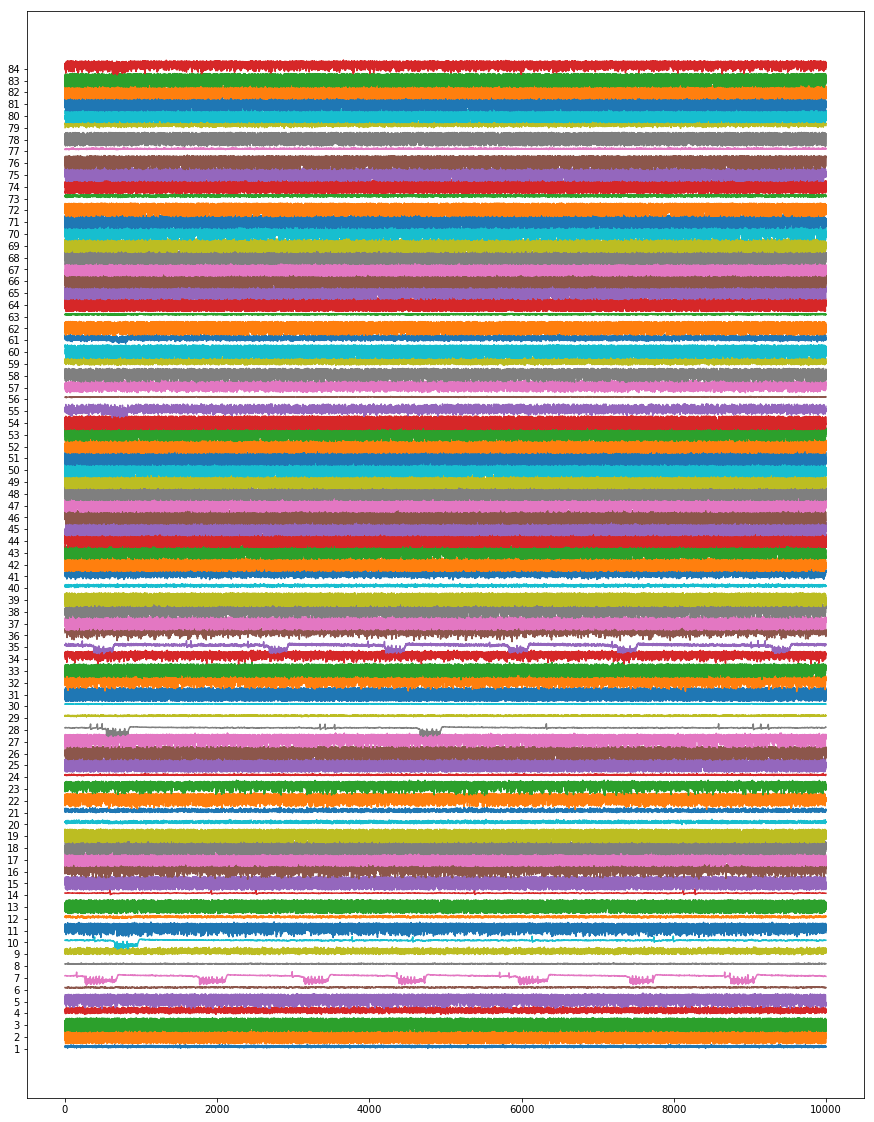

In [22]:
import importlib
importlib.reload(lib.io.stan);
csv_fname = 'results/exp7/exp7.1/samples_eps0.00200_chain1.csv'
nwarmup = 500
nsampling = 50
ignore_warmup = True
hmc_samples = lib.io.stan.read_samples(csv_fname,nwarmup,nsampling,ignore_warmup)

plt.figure(figsize=[15,20])
plt.plot(hmc_samples['x'][0,:,:]/4.0 + np.r_[0:84]);
plt.yticks(np.r_[0:84], np.r_[1:85]);


In [ ]:
def mov_avg(x,win_size):
    y = np.zeros(len(x))
    for i in range(len(x)-win_size):
        y[i] = np.mean(x[i:i+win_size])
    return y

sim_data = lib.io.stan.rload(f'{results_dir}/sim_data.R')
sim_out = lib.io.stan.parse_csv(f'{results_dir}/sim_out.csv')
chains = [1,2,3,4,5,6,7,8]
for i,chain_no in enumerate(chains):
    t = lib.io.stan.parse_csv(f'{results_dir}/samples_chain{chain_no}.csv')
    plt.figure(figsize=[10,8])
    for j in range(sim_data['nn']):
        plt.subplot(sim_data['nn']+1,1,j+1)
        start_idx = 0
        end_idx = sim_data['nt']
        x = t['x'][500:,j,start_idx:end_idx]
        xmu = np.mean(x,axis=0)
        plt.violinplot(x)
        plt.plot(np.r_[start_idx:end_idx]-start_idx+1,sim_out['x'][0,j,start_idx:end_idx],'k*')
#         plt.plot(np.r_[start_idx:end_idx]-start_idx+1,stats.mode(x)[0][0],'r*')
        plt.plot(np.r_[start_idx:end_idx]-start_idx+1,mov_avg(xmu,20),'r*')
        plt.xlabel('time',fontsize=13)
        plt.ylabel('x(t)',fontsize=13)
    plt.suptitle(f'chain {chain_no}')
    plt.tight_layout()